# 프로젝트: 더 멋진 번역기 만들기

In [1]:
# 노드 8. Seq2seq으로 번역기 만들기 참고 데이터 전처리 준비

import tensorflow as tf
import keras
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from tqdm import tqdm
from tqdm import tqdm_notebook    # Process 과정을 보기 위해
import random

import sentencepiece as spm
from konlpy.tag import Mecab

In [2]:
# 노드 8. Seq2seq으로 번역기 만들기 참고- 글꼴 설치

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

print("완료!")

완료!


In [3]:
#  GPU out of memory 문제로 코드 추가  * 부족현상 확인시 추가 예정 
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)

## Step 1. 데이터 다운로드 (클라우드 유저용)

[학습환경 구성 및 데이터 다운]
 
- mkdir -p ~/aiffel/transformer/data
- cd ~/aiffel/transformer/data

- wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
- gzip -d korean-english-park.train.tar.gz  
    - 압축 명령어 : gzip은 압축이 성공하면 기존 원본파일은 모두 사라지고 .gz 확장자를 가진 파일이 새롭게 생성된다. -d 압축해제

- tar -xzvf korean-english-park.train.tar.gz  
   - tar -x : tar 아카이브에서 파일 추출. (파일 풀 때 사용) 
   - tar -z : gzip 압축 적용 옵션, 
   - tar -v : 처리되는 과정(파일 정보)을 자세하게 나열, 
   - tar -f : 대상 tar 아카이브 지정. (기본 옵션)

## Step 2. 데이터 정제 및 토큰화

In [4]:
data_dir = os.getenv('HOME') + '/aiffel/transformer/data/'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng) # 같은 갯수라는것을 검증 받기 위해 적용한다.

    cleaned_corpus = list(set(zip(kor, eng)))  # 중복된 데이터 제거한다.

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

#### (1) 데이터정제

In [5]:
# 노드 8. Seq2seq으로 번역기 만들기, 12노드 참고- 데이터 정제하기

def preprocess_sentence(sentence):  #preprocess_sentence :  문장부호와 대소문자등을 정제하는 함수
    
    sentence = sentence.lower()   # 모든 입력을 소문자로 변환
   
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence)  # 알파벳, 문장부호, 한글만 남기고 모두 제거
   
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 문장부호 양옆에 공백 추가
   
    sentence = re.sub(r'[" "]+', " ", sentence)   # 문장 앞뒤의 불필요한 공백 제거
    
    return sentence

#### (2) 토크나이저준비

In [6]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성 , 12. 번역가는 대화에도 능하다 노드 참고

def generate_tokenizer(corpus,
                       vocab_size,
                       lang="ko",
                       pad_id=0,   # pad token의 일련번호
                       bos_id=1,  # 문장의 시작을 의미하는 bos token(<s>)의 일련번호
                       eos_id=2,  # 문장의 끝을 의미하는 eos token(</s>)의 일련번호
                       unk_id=3):   # unk token의 일련번호
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write(str(row) + '\n')

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer
print("슝=3")

슝=3


In [7]:
cleaned_corpus[4]

('또 양국은 북한 핵 문제에 있어서 파트너 관계를 형성하고 있다.',
 'And the countries are partners in international efforts to persuade North Korea to abandon its nuclear weapons.')

In [8]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]
    # kor, eng 나눠서 데이터 정제 후 분리
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [9]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):

    src_tokens = ko_tokenizer.encode_as_ids(kor_corpus[idx])   # 위의 코드에서 ko_tokenizer 참고 
    tgt_tokens = en_tokenizer.encode_as_ids(eng_corpus[idx])   # 위의 코드에서 en_tokenizer 참고 

    if len(src_tokens) <= 50 and len(tgt_tokens) <= 50:
    
        src_corpus.append(src_tokens)
        tgt_corpus.append(tgt_tokens)


100%|██████████| 78968/78968 [00:04<00:00, 15835.36it/s]


In [10]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

## Step 3. 모델 설계

#### (3) Positional Encoding  (위치)

In [11]:
def positional_encoding(pos, d_model): # pos - 단어가 위치한 Time-step(토큰의 위치정보), d_model - 모델의 Embedding 차원 수
    def cal_angle(position, i): # i - Encoding차원의 index
        
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2]) #  배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용

    return sinusoid_table

#### (4) Multi-head Attention

In [12]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

#### (5) Position-wise Feed Forward Network

In [13]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

#### (6) Encoder Layer

In [14]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

#### (7) Decoder Layer

In [15]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out,padding_mask )
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

#### (8) Encoder

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

#### (9) Decoder

In [17]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

#### (10) Transformer 전체 모델 조립

In [18]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):   #????????????
        
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model) # 1. Embedding Layer 정의
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)  # 2. Positional Encoding 정의
        self.do = tf.keras.layers.Dropout(dropout)   # 6. Dropout 정의

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)  # 3. Encoder / Decoder 정의
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)  # 4. Output Linear 정의

        self.shared = shared  # 5. Shared Weights

        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        # Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        # Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        # Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

#### (11) 마스크 생성

In [19]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

- <mark> 12번 12. 번역가는 대화에도 능하다 노드 순서에 따라 마스크 생성 Transformer 전체 모델 조립 전에 넣으면 훈련 학습 이후 오류발생
이에 Transformer 전체 모델 조립 이후에 마스크 생성으로 마무리할것 </mark>

## Step 4. 훈련하기

####  (12) Learning Rate Scheduler * 학습시키기

In [20]:
# Learning Rate Scheduler 구현

class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

#### (13) Learning Rate & Optimizer

In [21]:
learning_rate = LearningRateScheduler(512)   # d_model=512, 하이퍼파라미터로 Transformer 인스턴스 생성

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

#### (13) Loss Function 정의

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

- NameError: name 'tf' is not defined 에러시 import tensorflow as tf 다시 불러와 보기

#### (14) Train Step 정의

In [23]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)
    
    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)
    
    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

### 번역 생성에는 아래 소스를 사용

In [24]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [25]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [33]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=True):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [34]:
examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

##### 모델 인스턴스 생성

In [28]:
#주어진 하이퍼파라미터로 Transformer 인스턴스 생성

transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

#### (15) Train *훈련 시키기

In [29]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 1


for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/1064 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the white house .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were not between they .
Input: 커피는 필요 없다.
Predicted translation: they is not been .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they were killed in .


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/1064 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president .
Encoder Layer 1


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


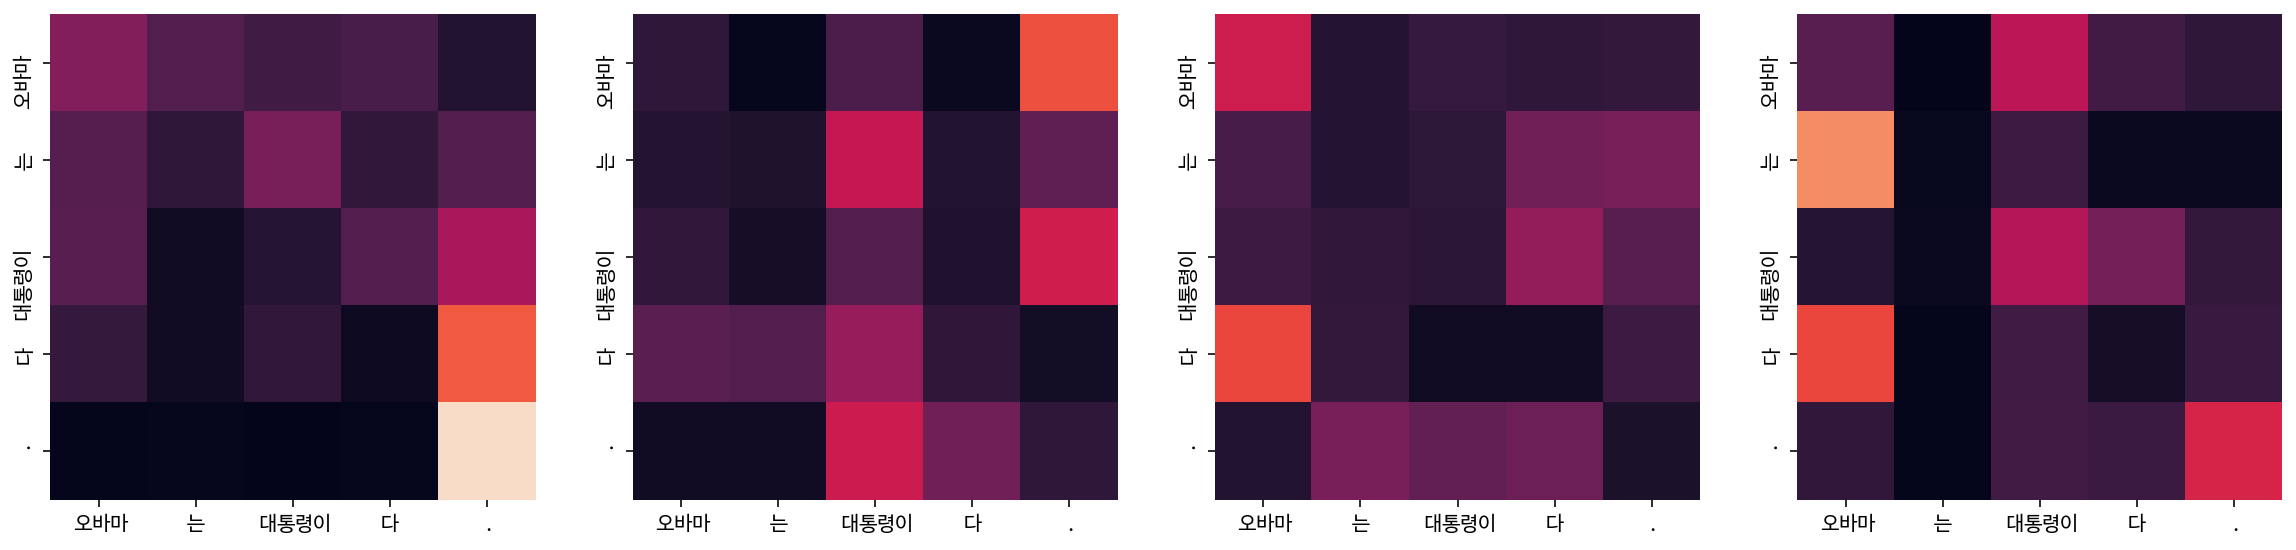

Encoder Layer 2


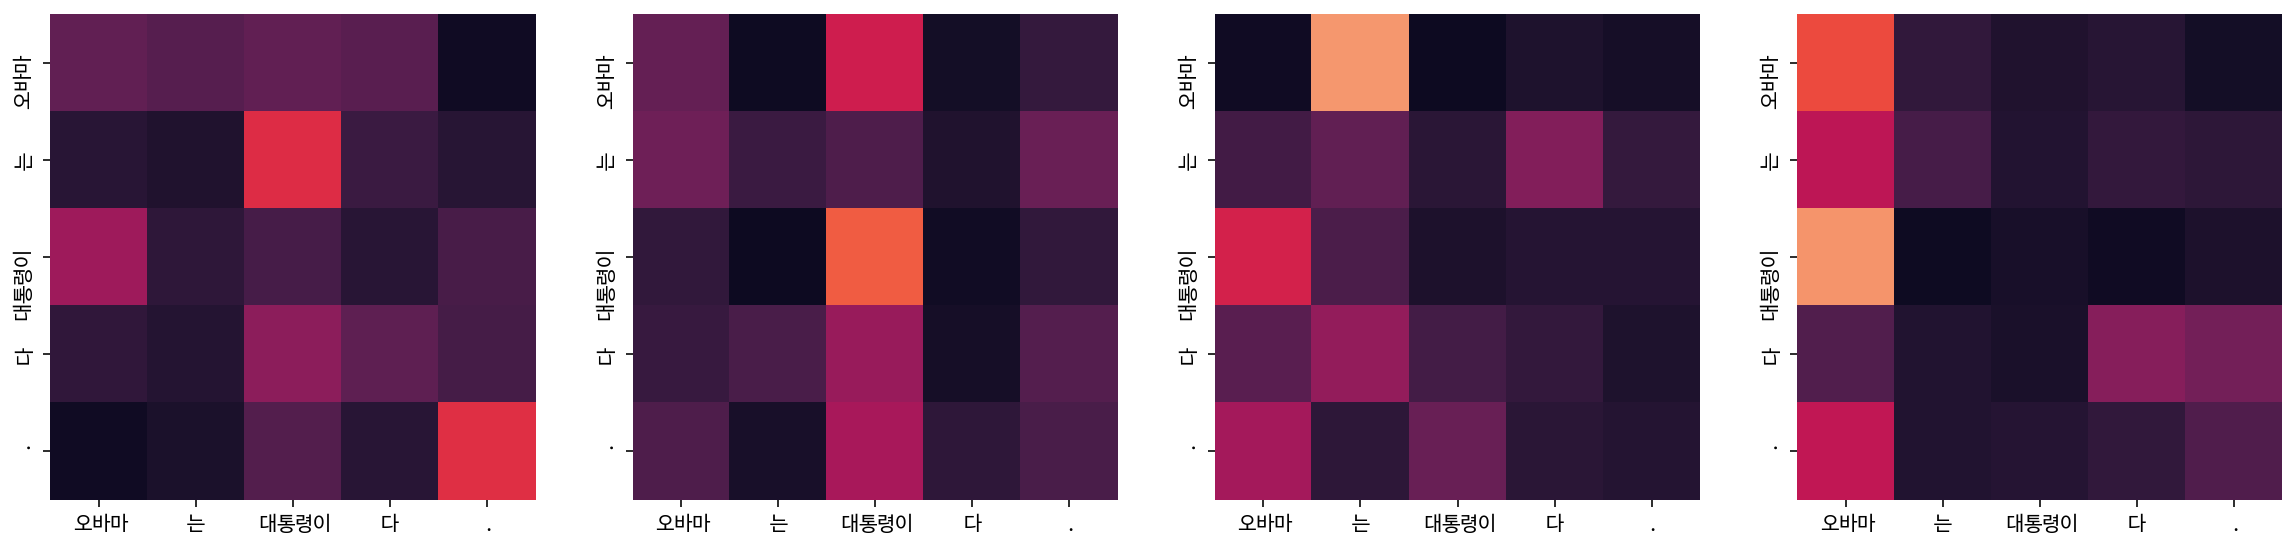

Decoder Self Layer 1


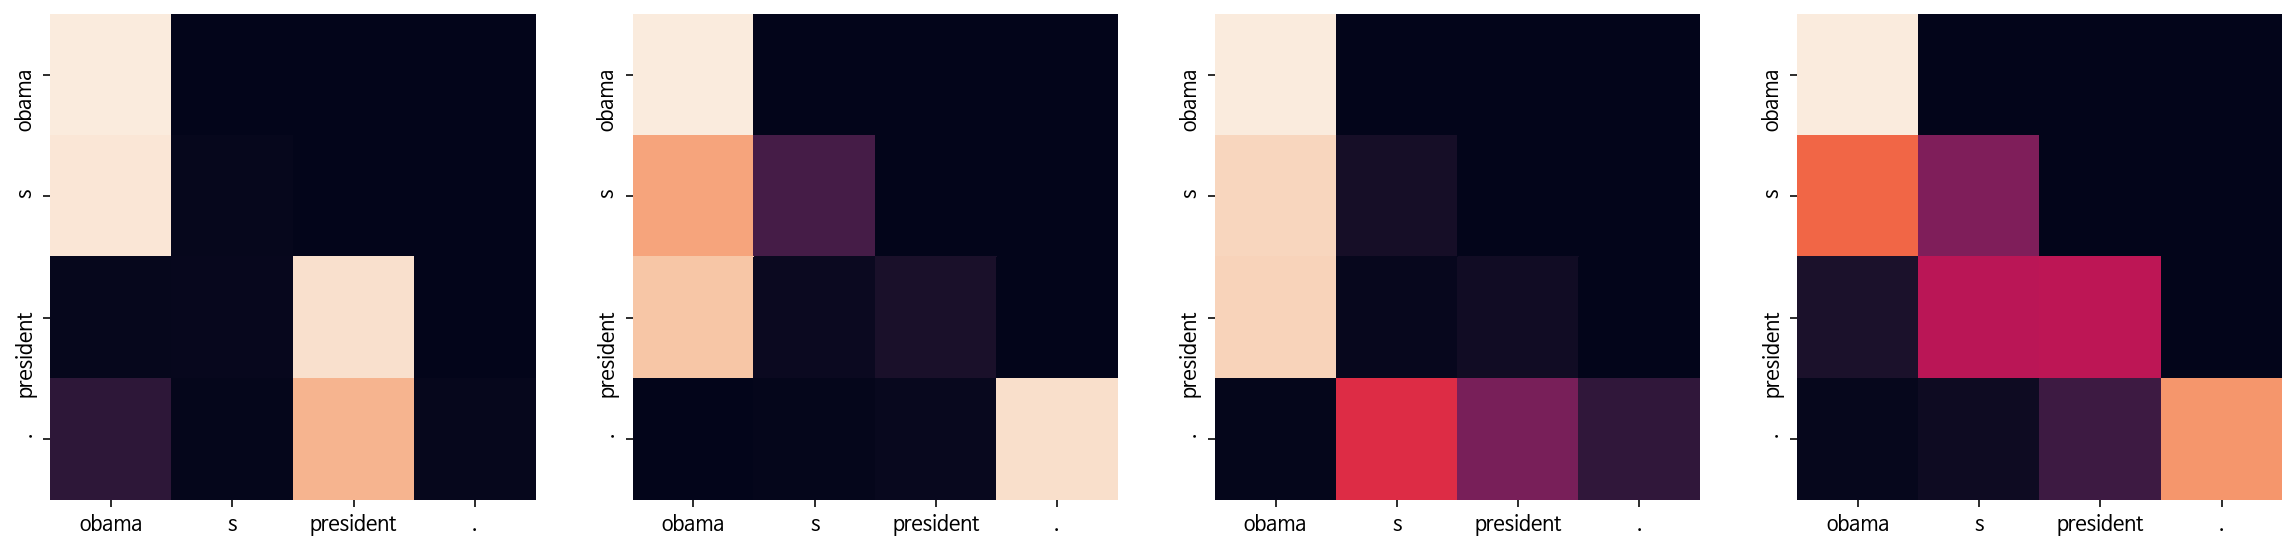

Decoder Src Layer 1


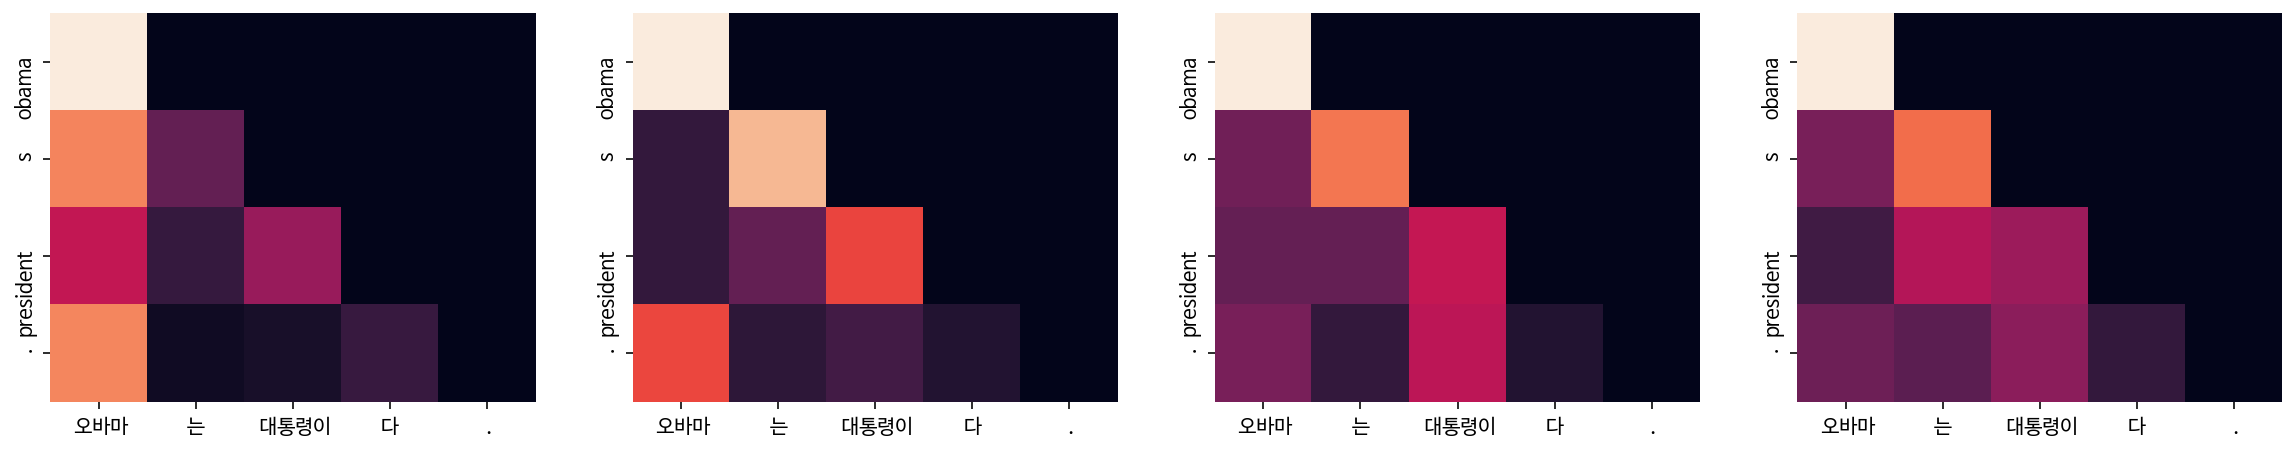

Decoder Self Layer 2


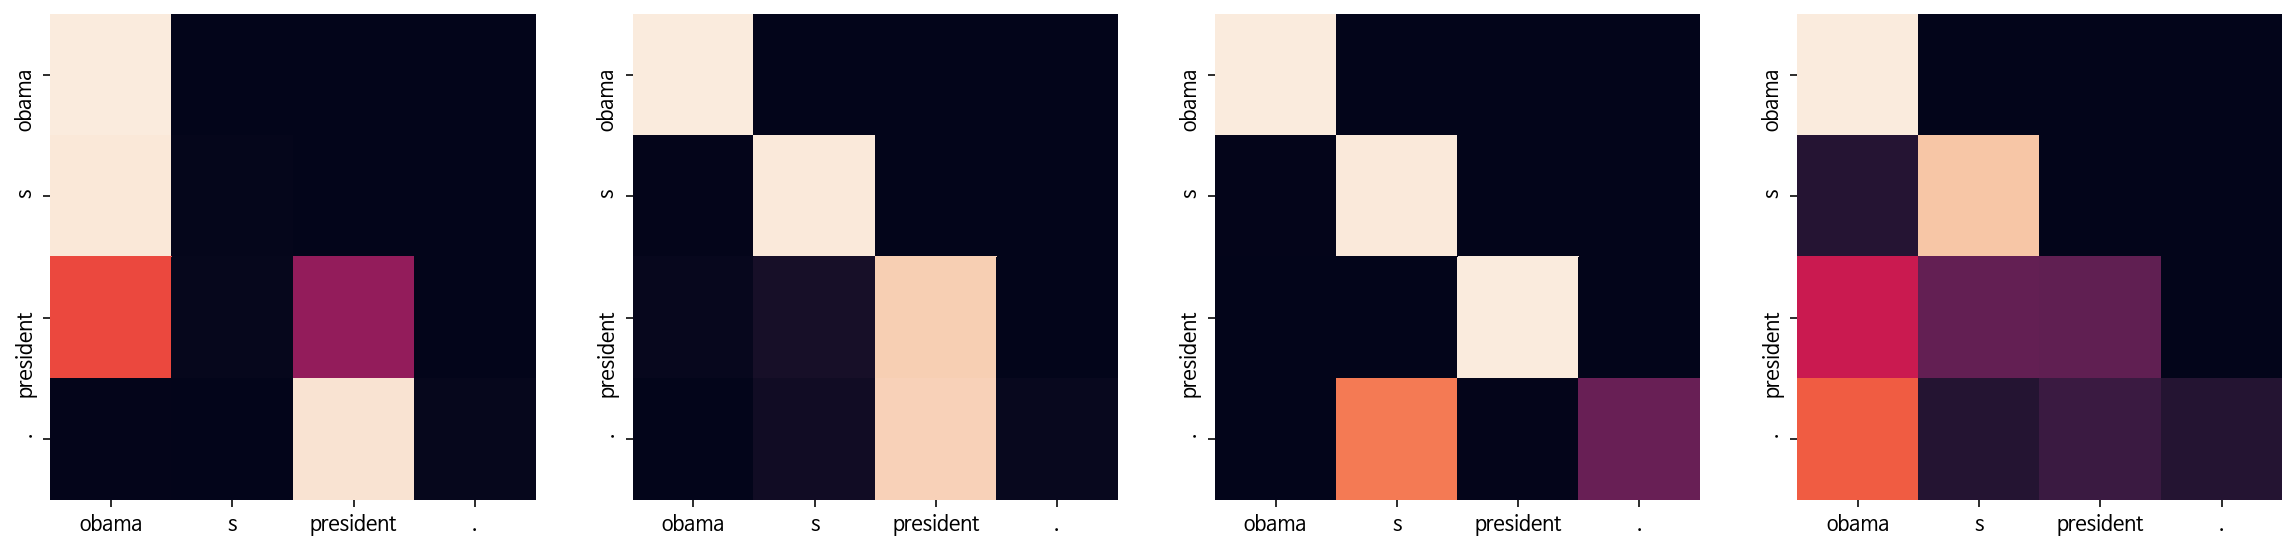

Decoder Src Layer 2


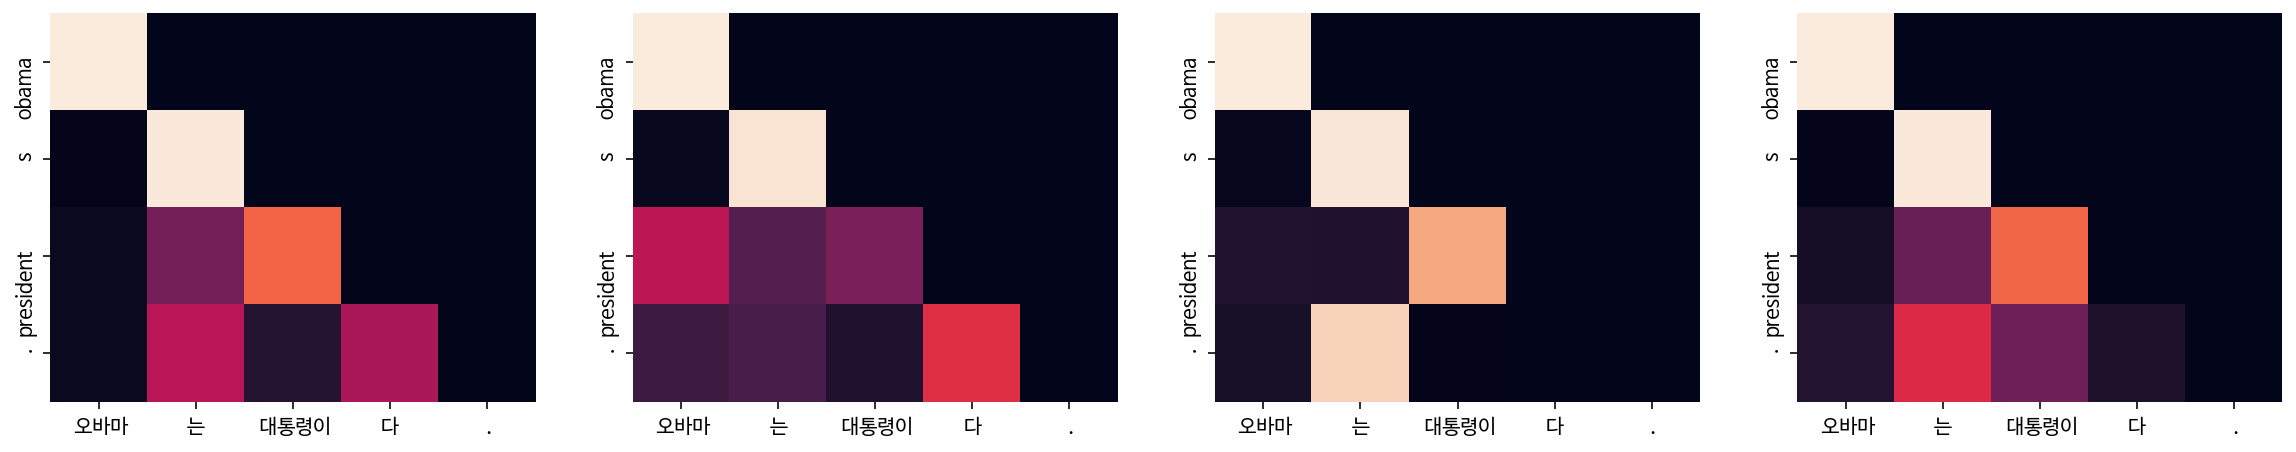

Input: 시민들은 도시 속에 산다.
Predicted translation: they are in the city .
Encoder Layer 1


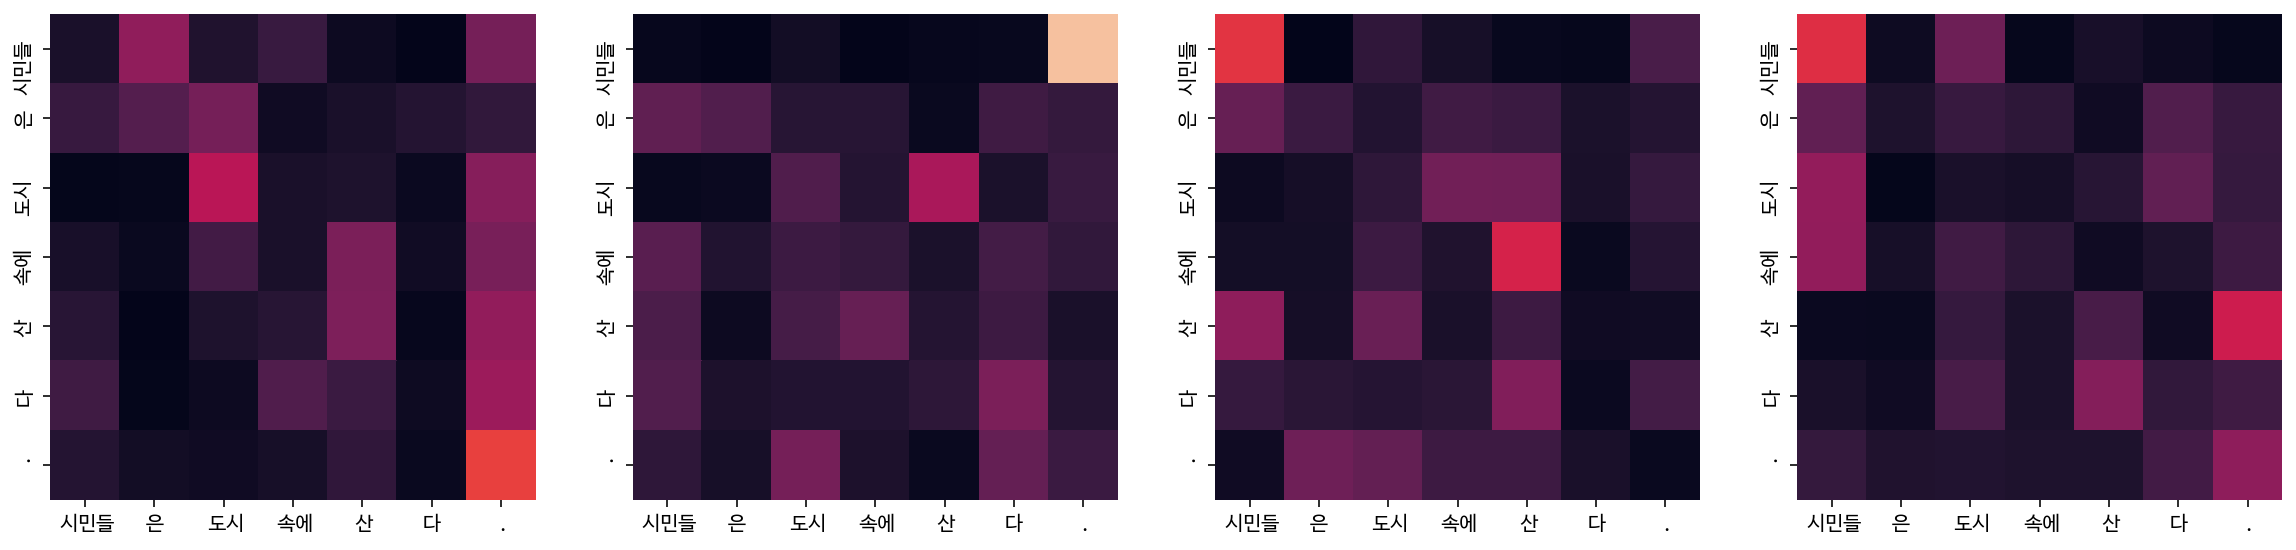

Encoder Layer 2


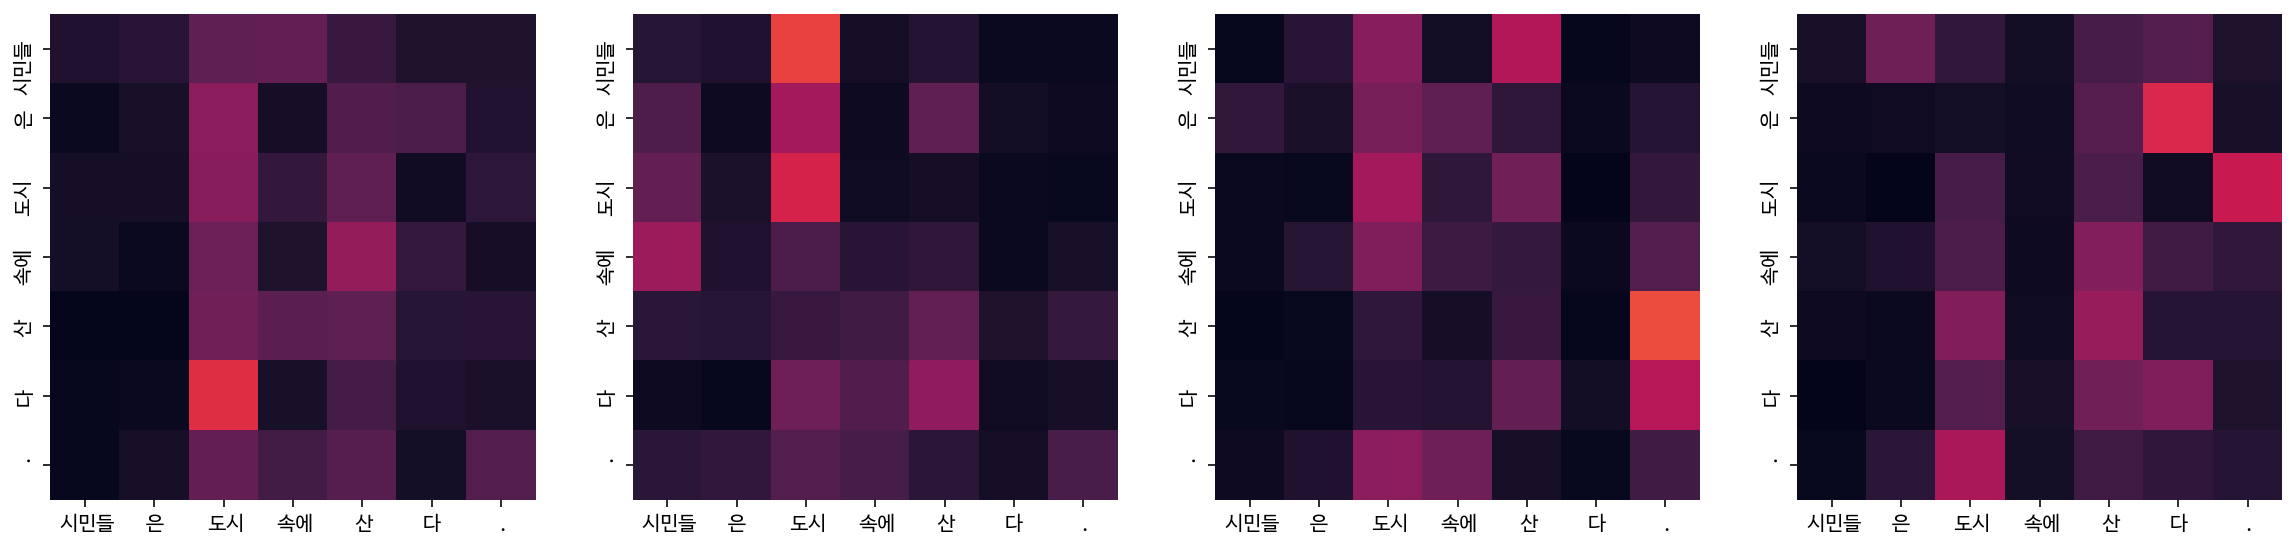

Decoder Self Layer 1


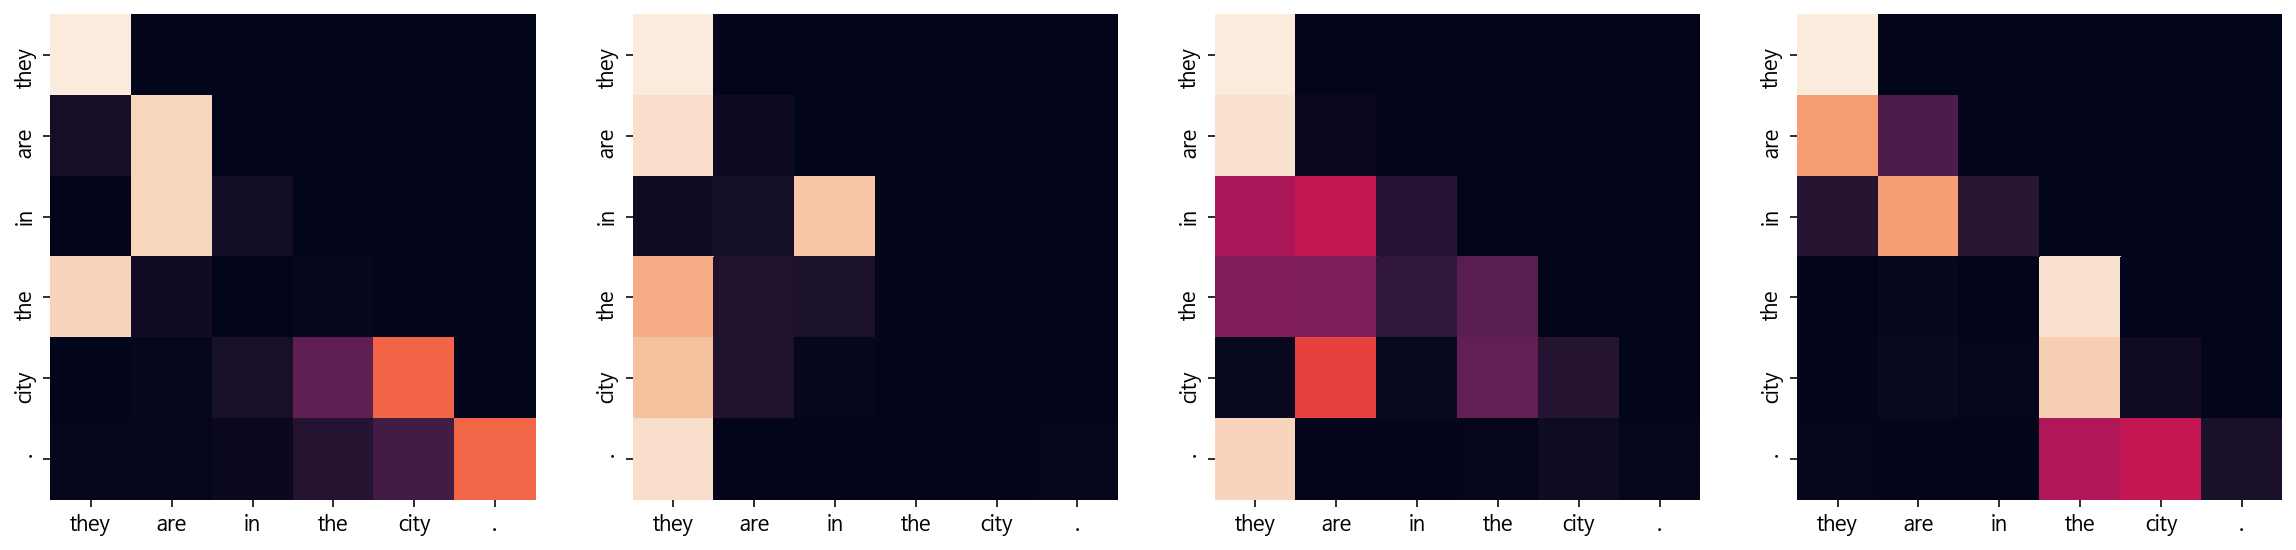

Decoder Src Layer 1


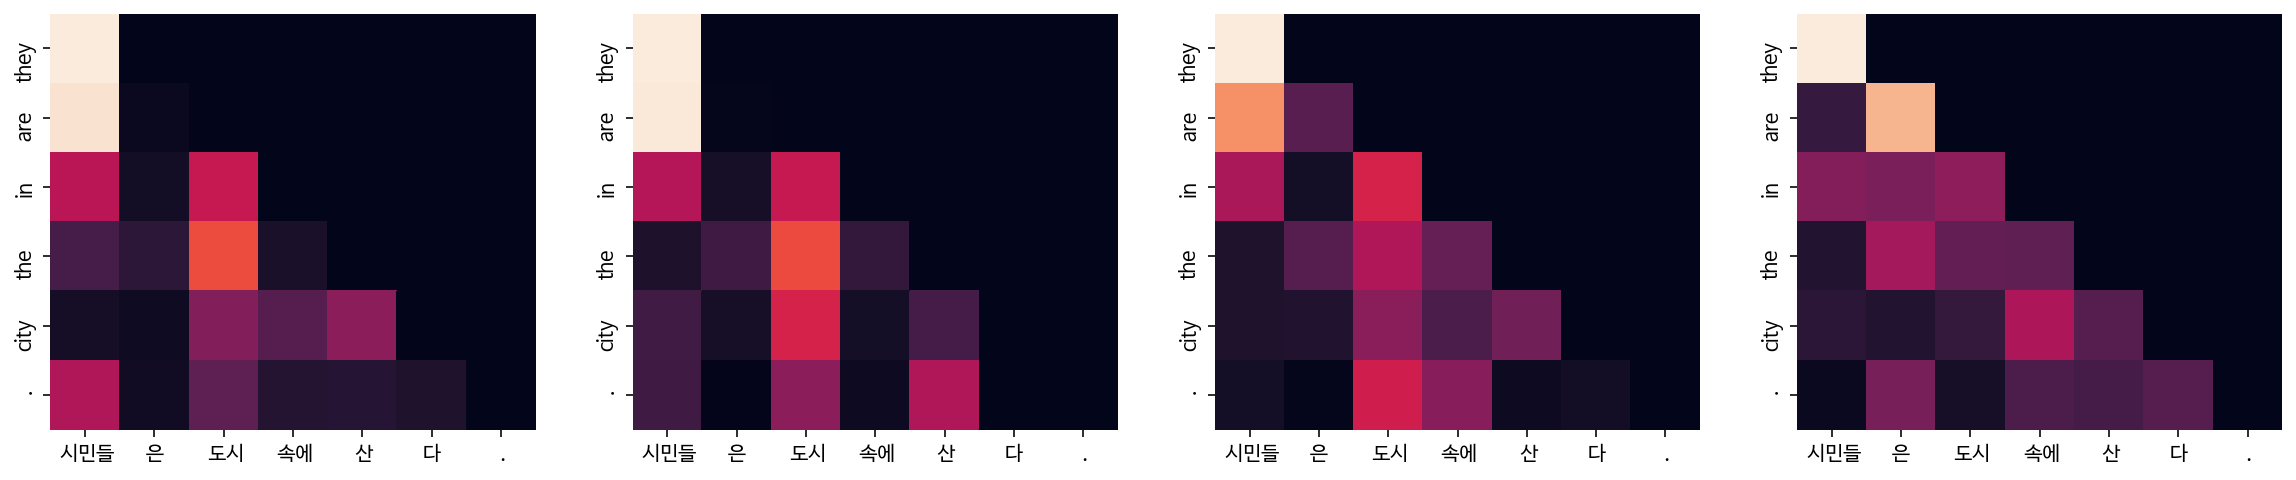

Decoder Self Layer 2


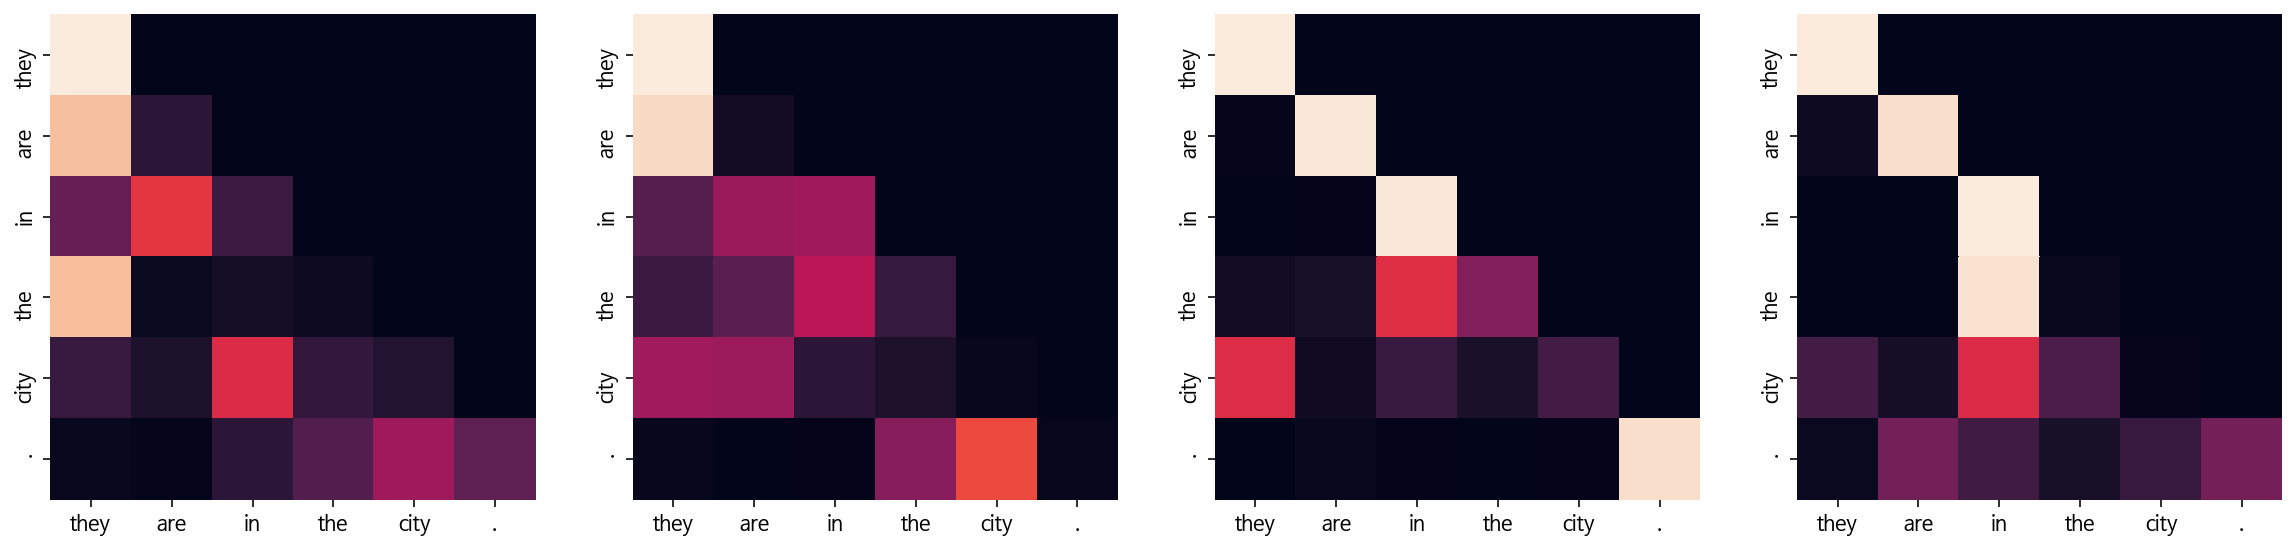

Decoder Src Layer 2


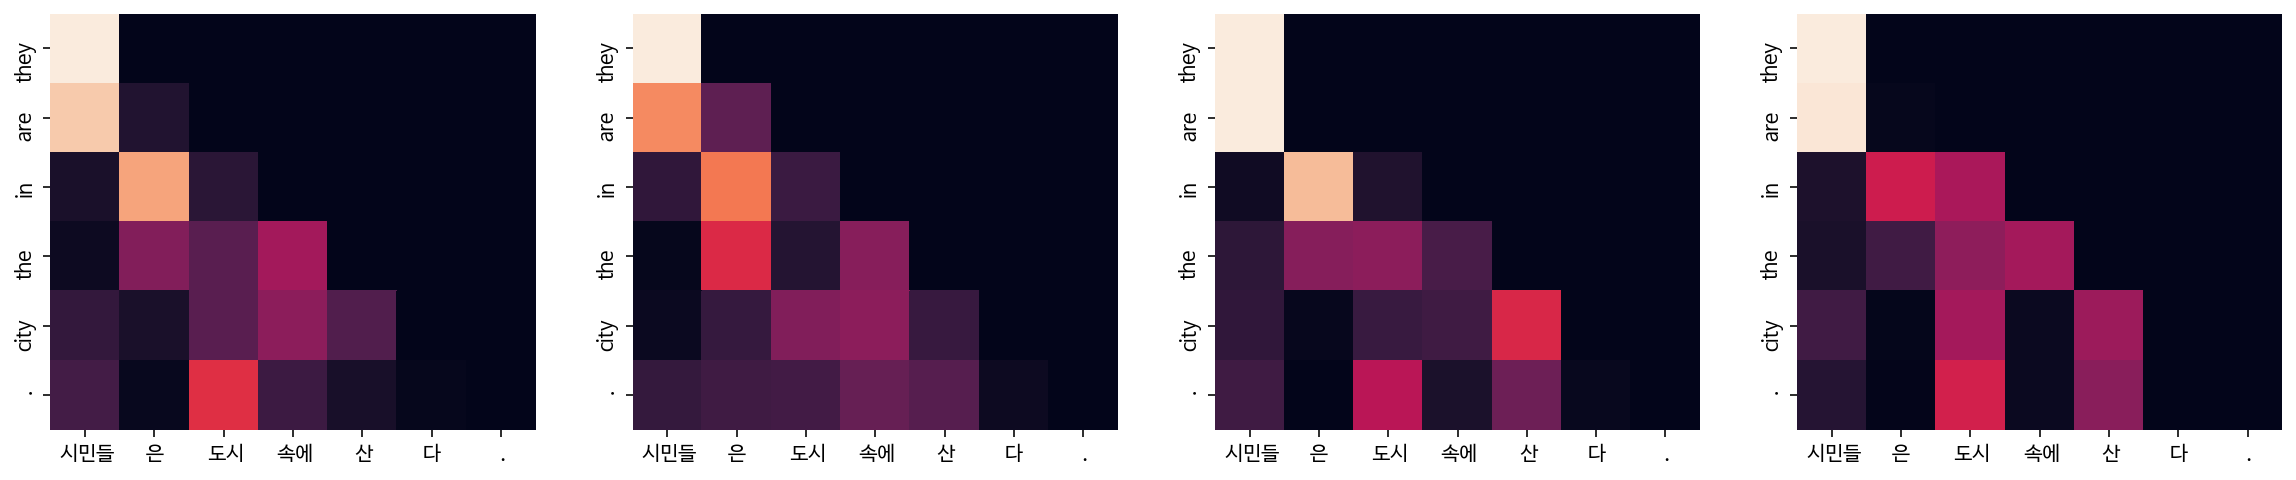

Input: 커피는 필요 없다.
Predicted translation: it was not a few years .
Encoder Layer 1


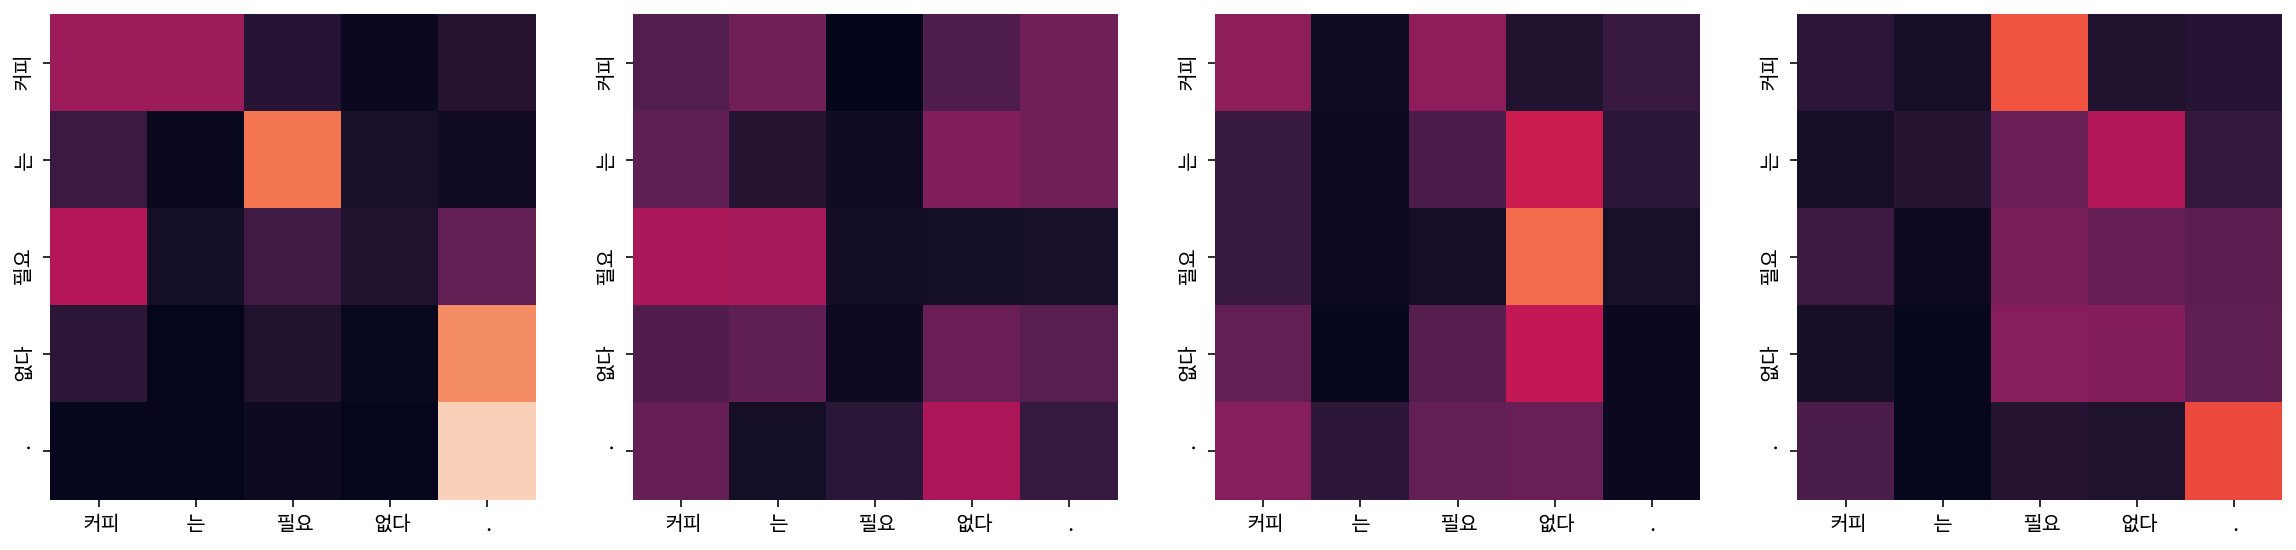

Encoder Layer 2


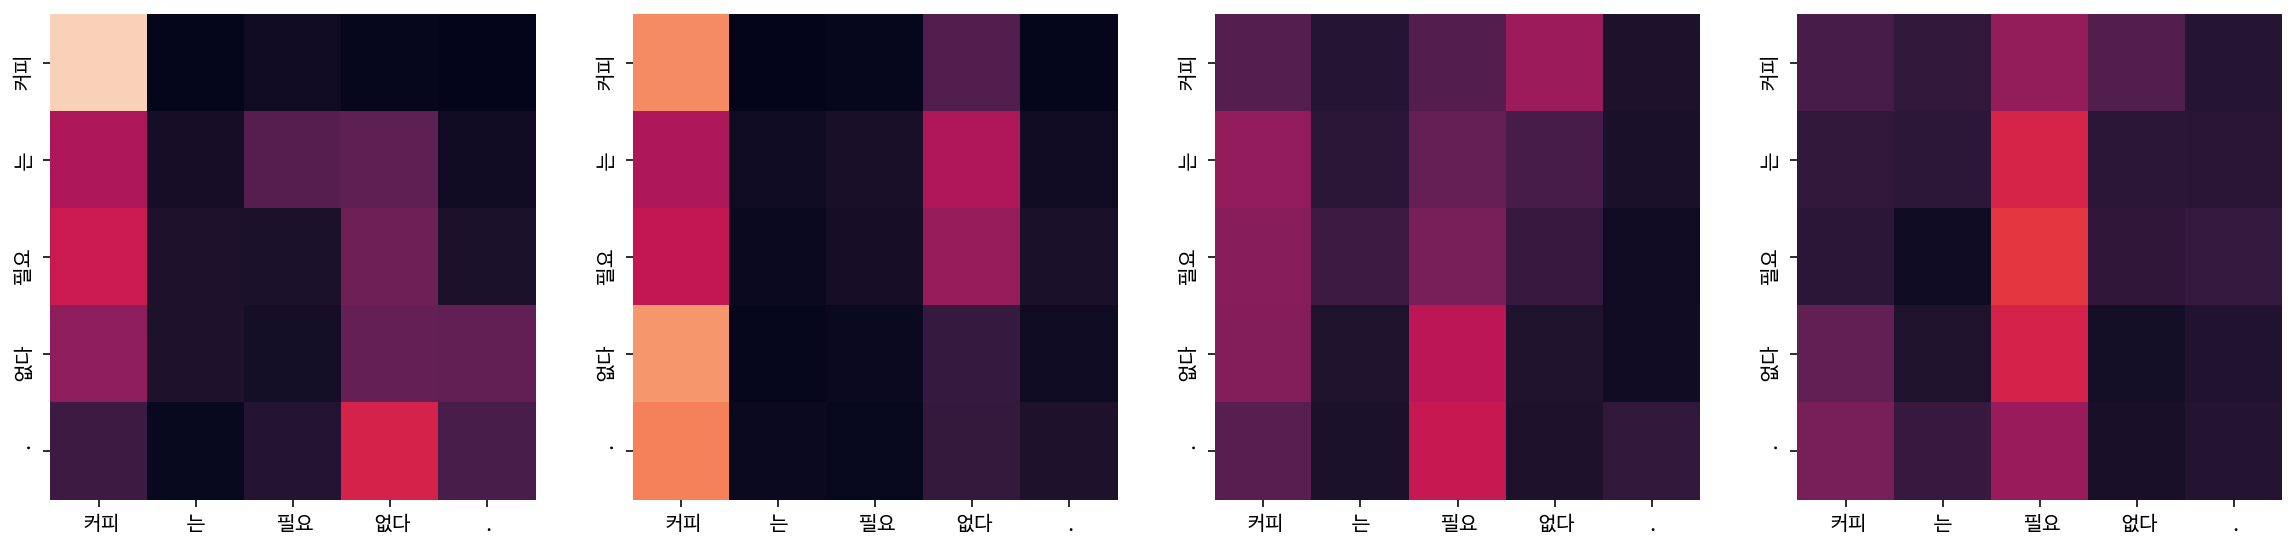

Decoder Self Layer 1


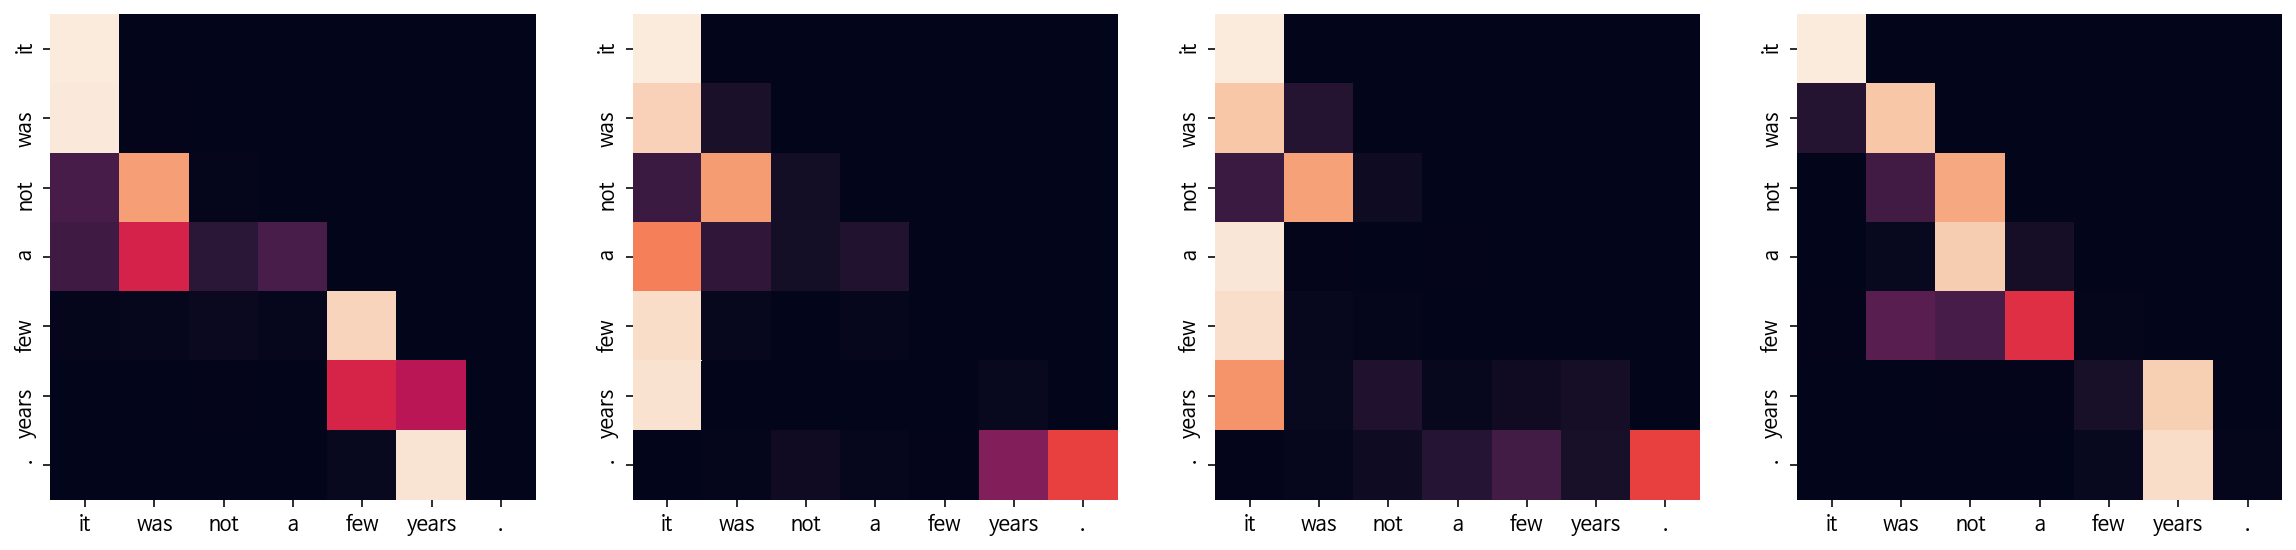

Decoder Src Layer 1


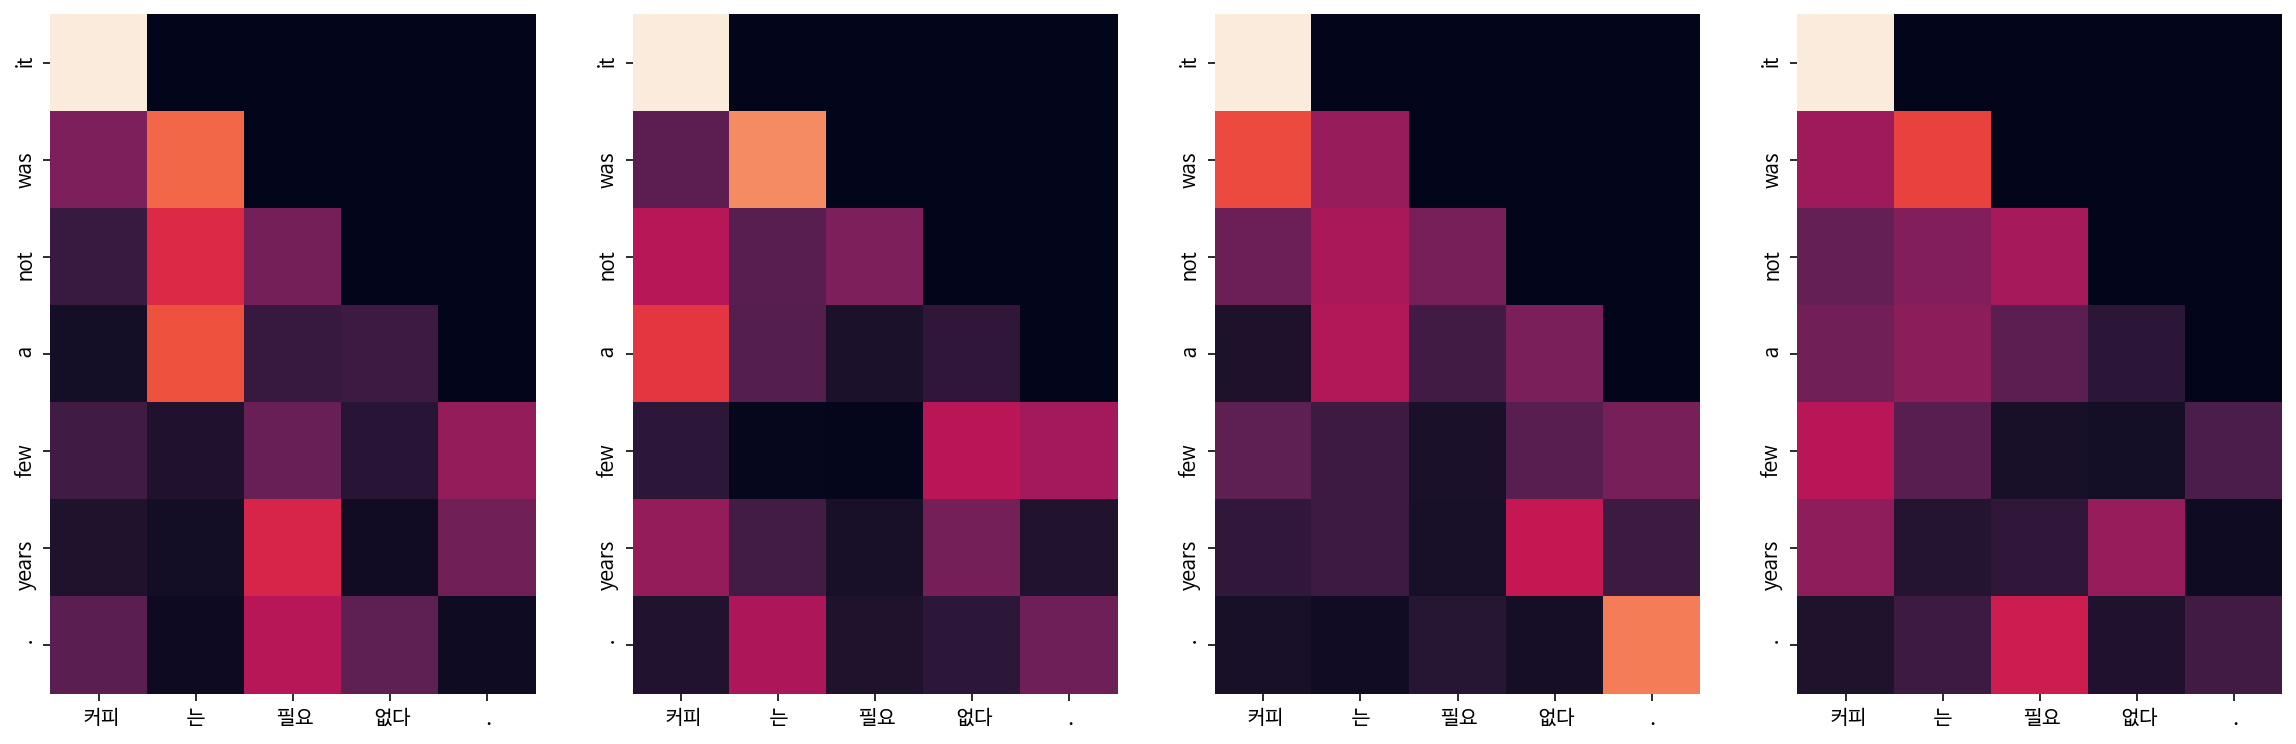

Decoder Self Layer 2


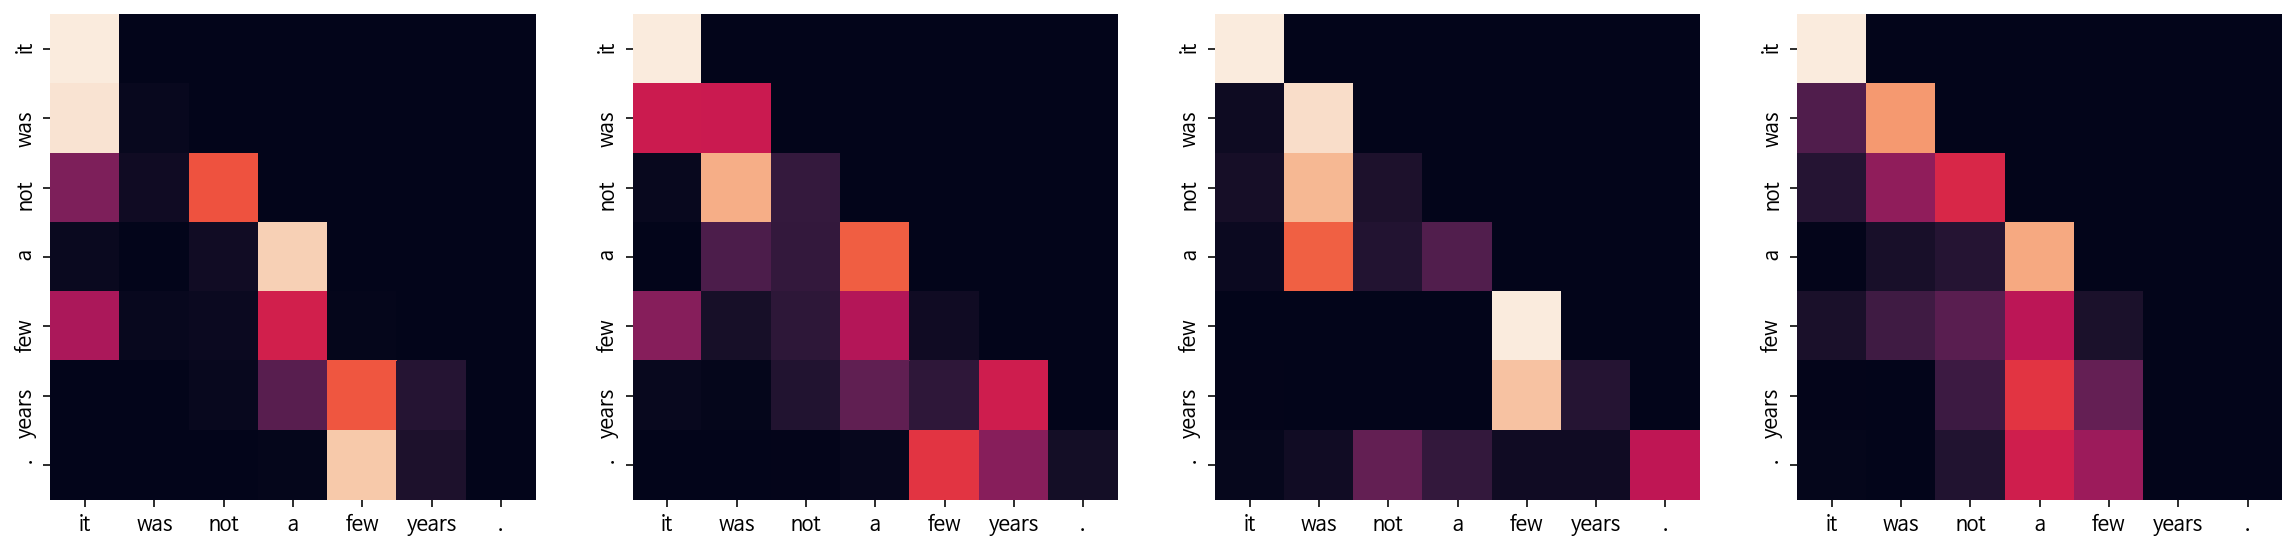

Decoder Src Layer 2


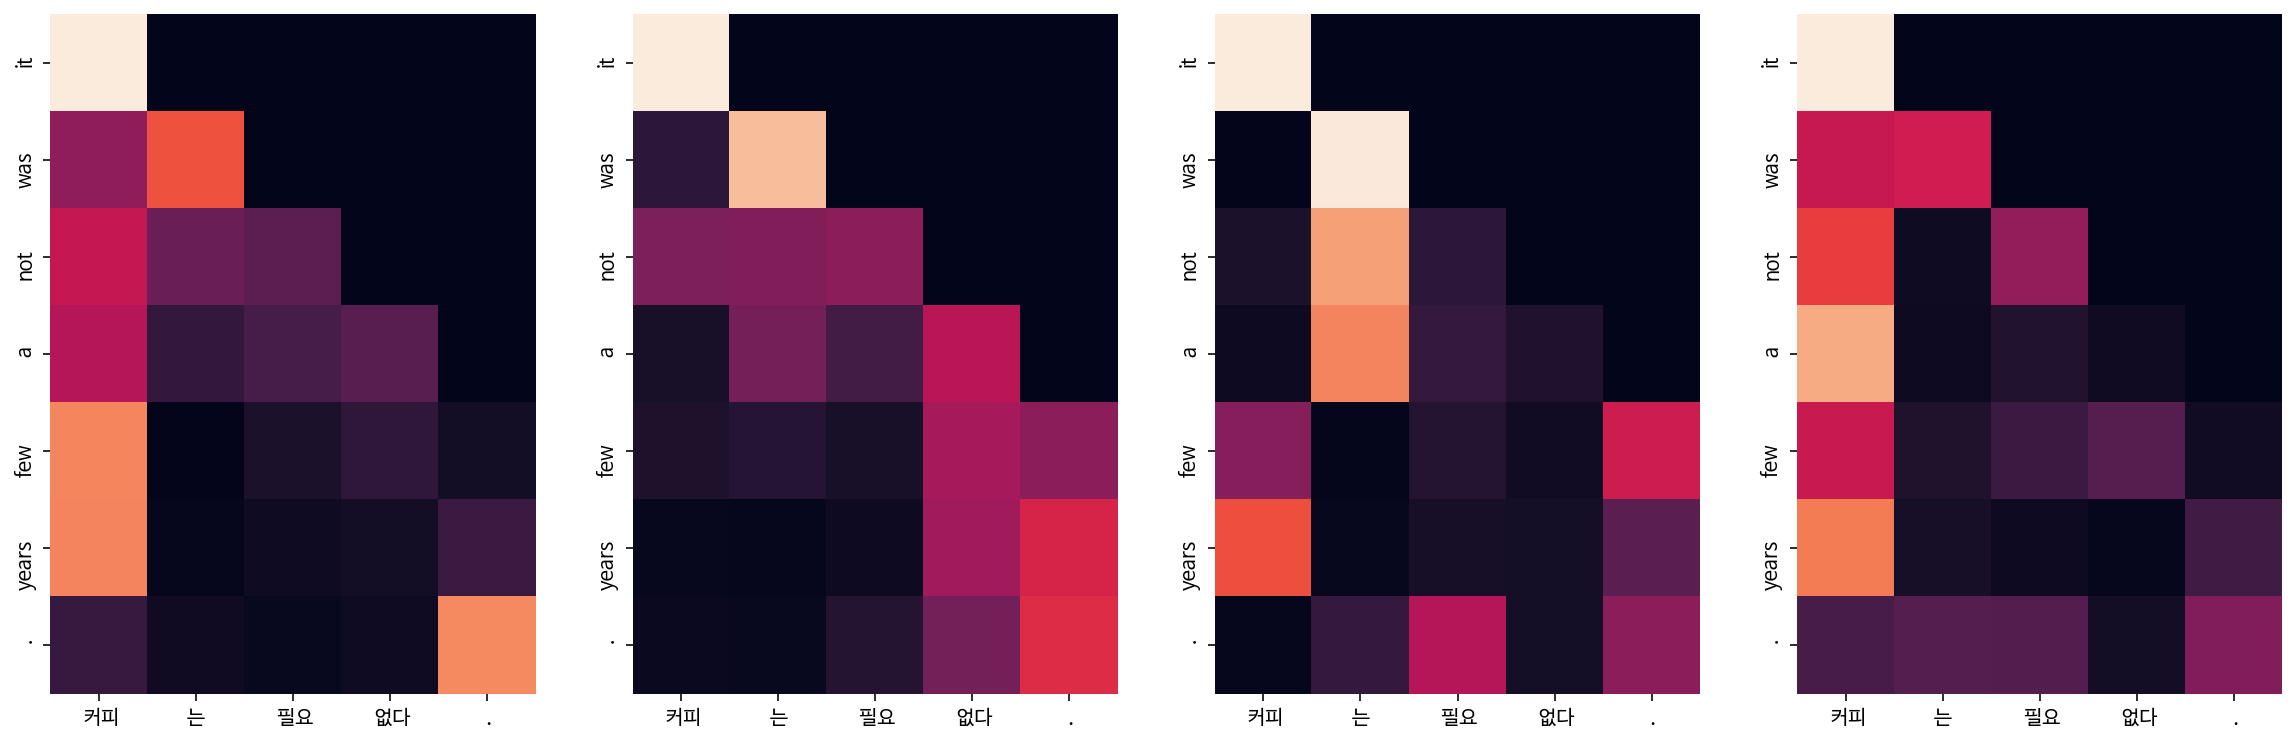

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on wednesday killed people and others were killed .
Encoder Layer 1


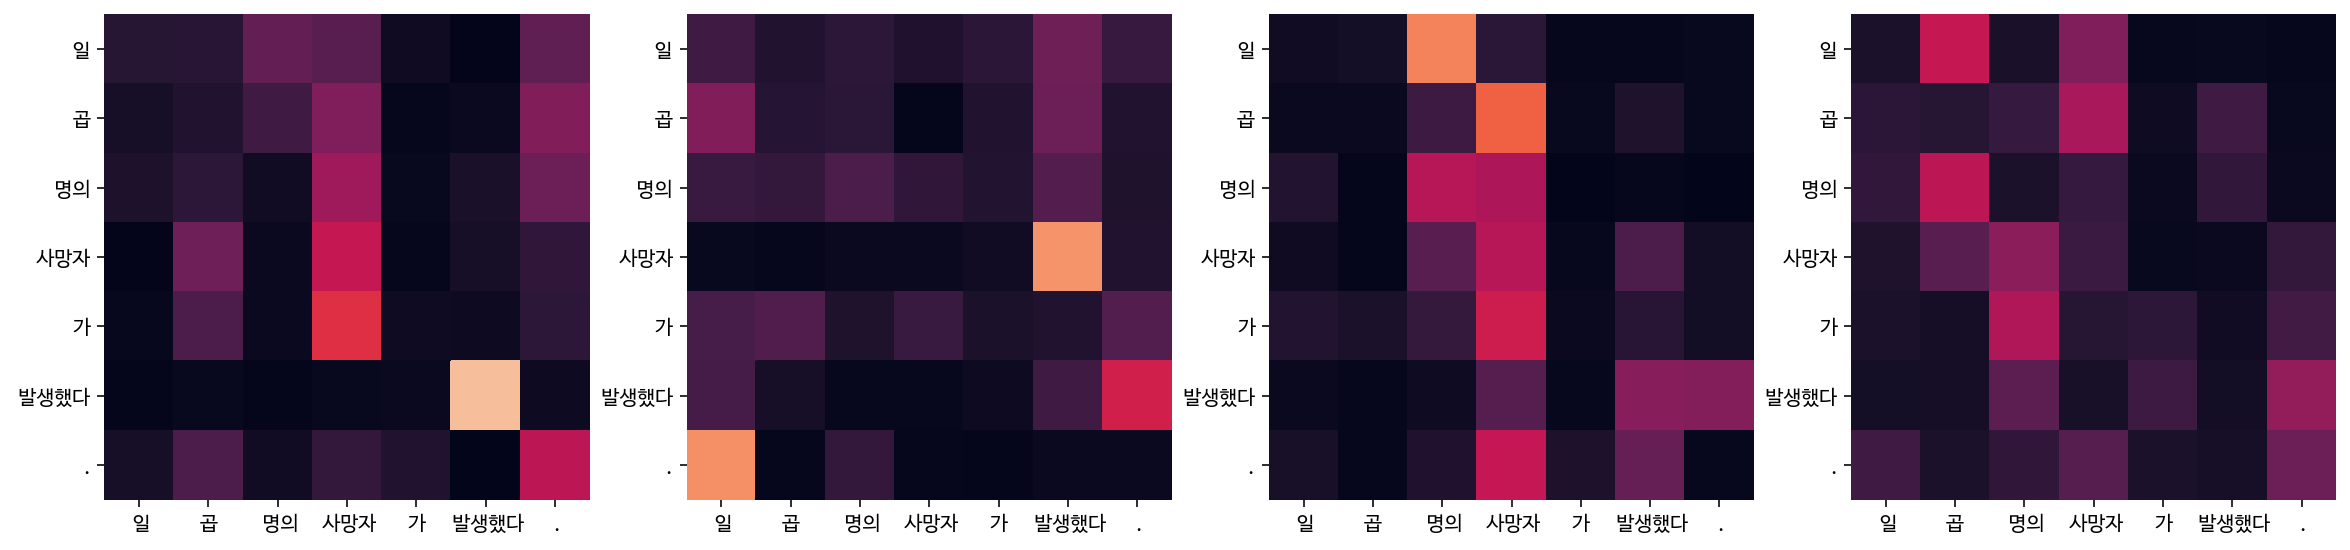

Encoder Layer 2


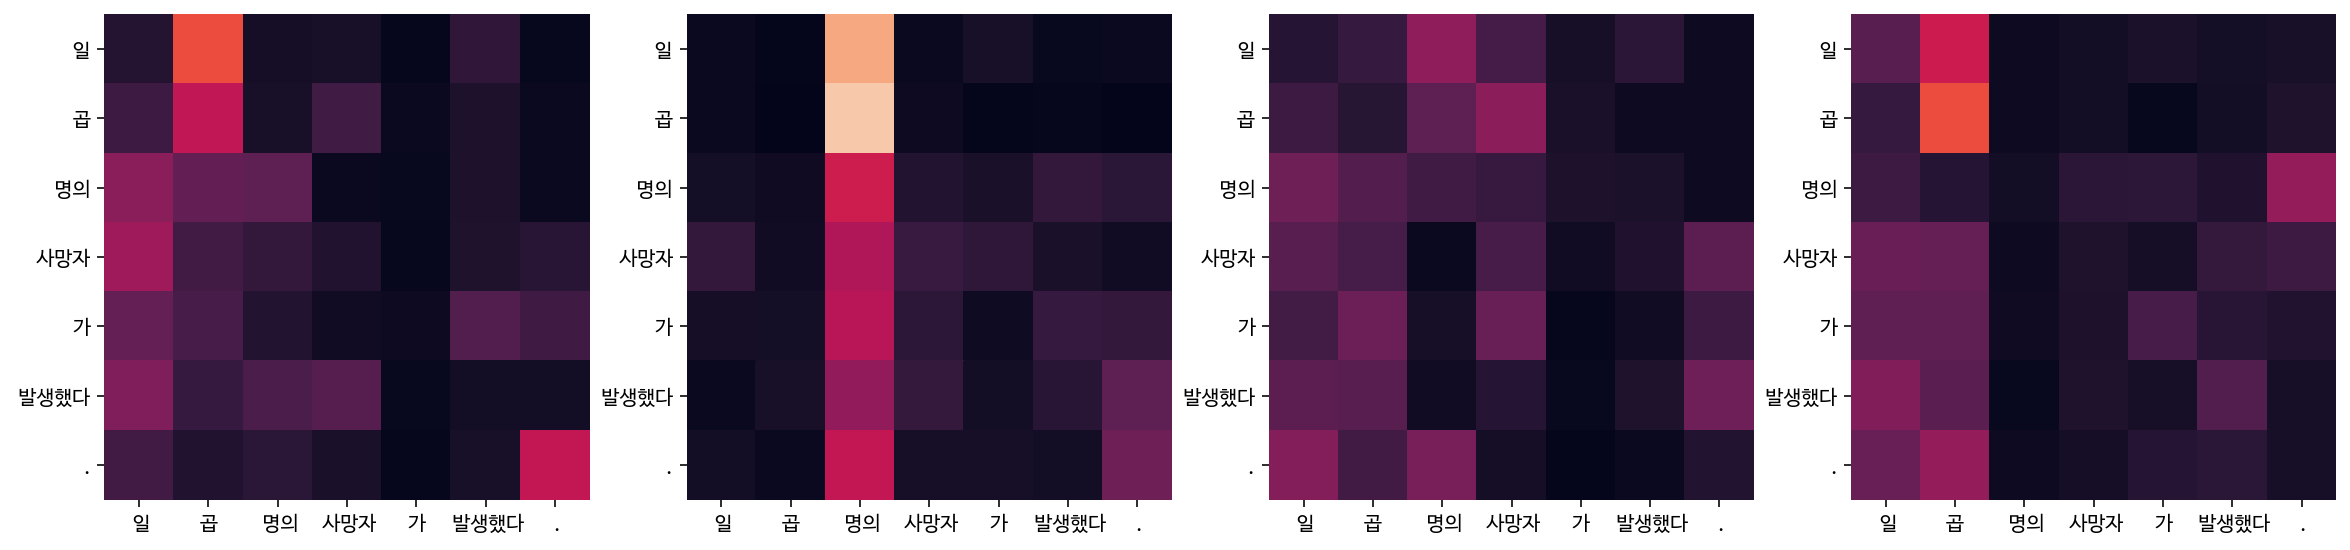

Decoder Self Layer 1


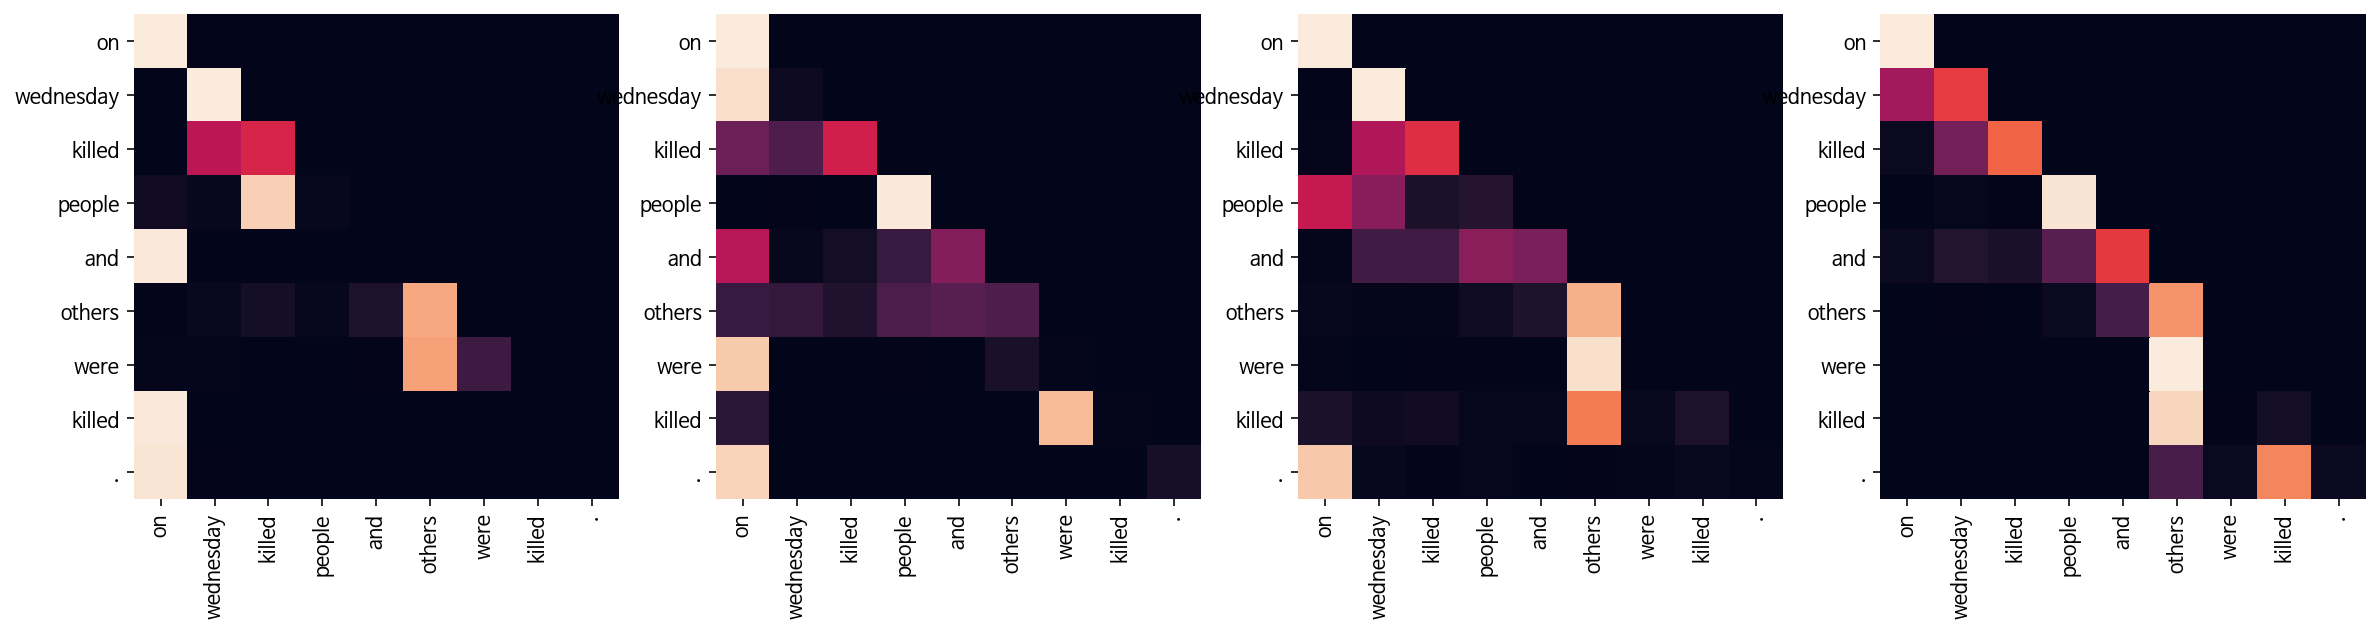

Decoder Src Layer 1


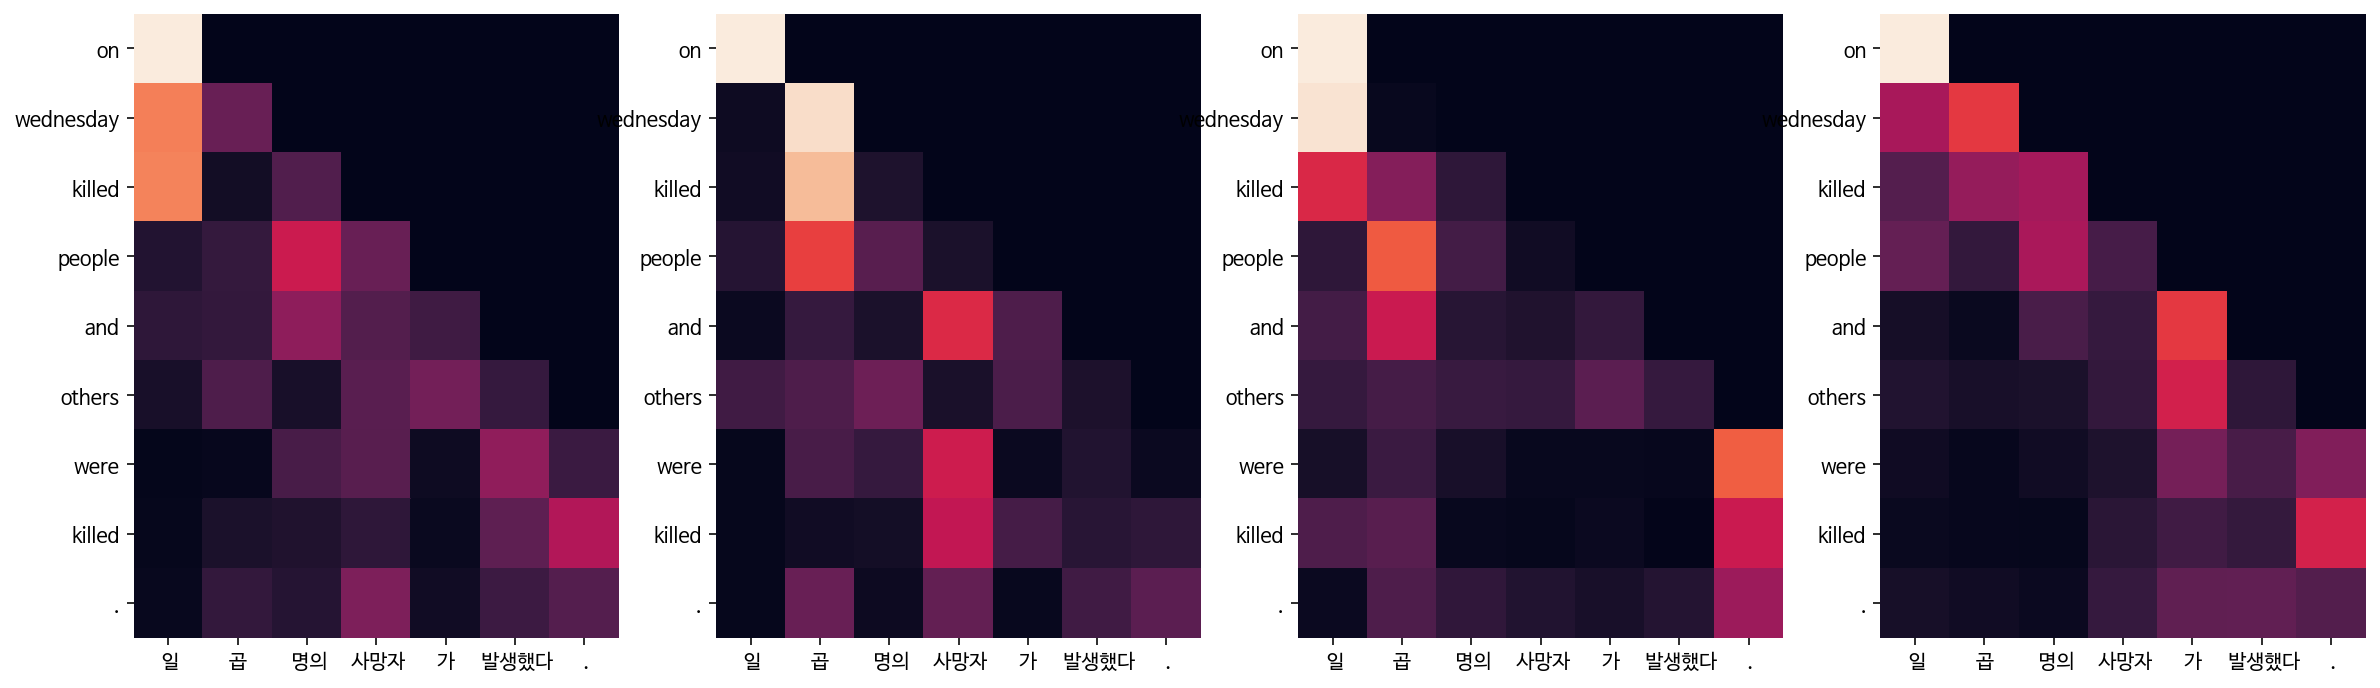

Decoder Self Layer 2


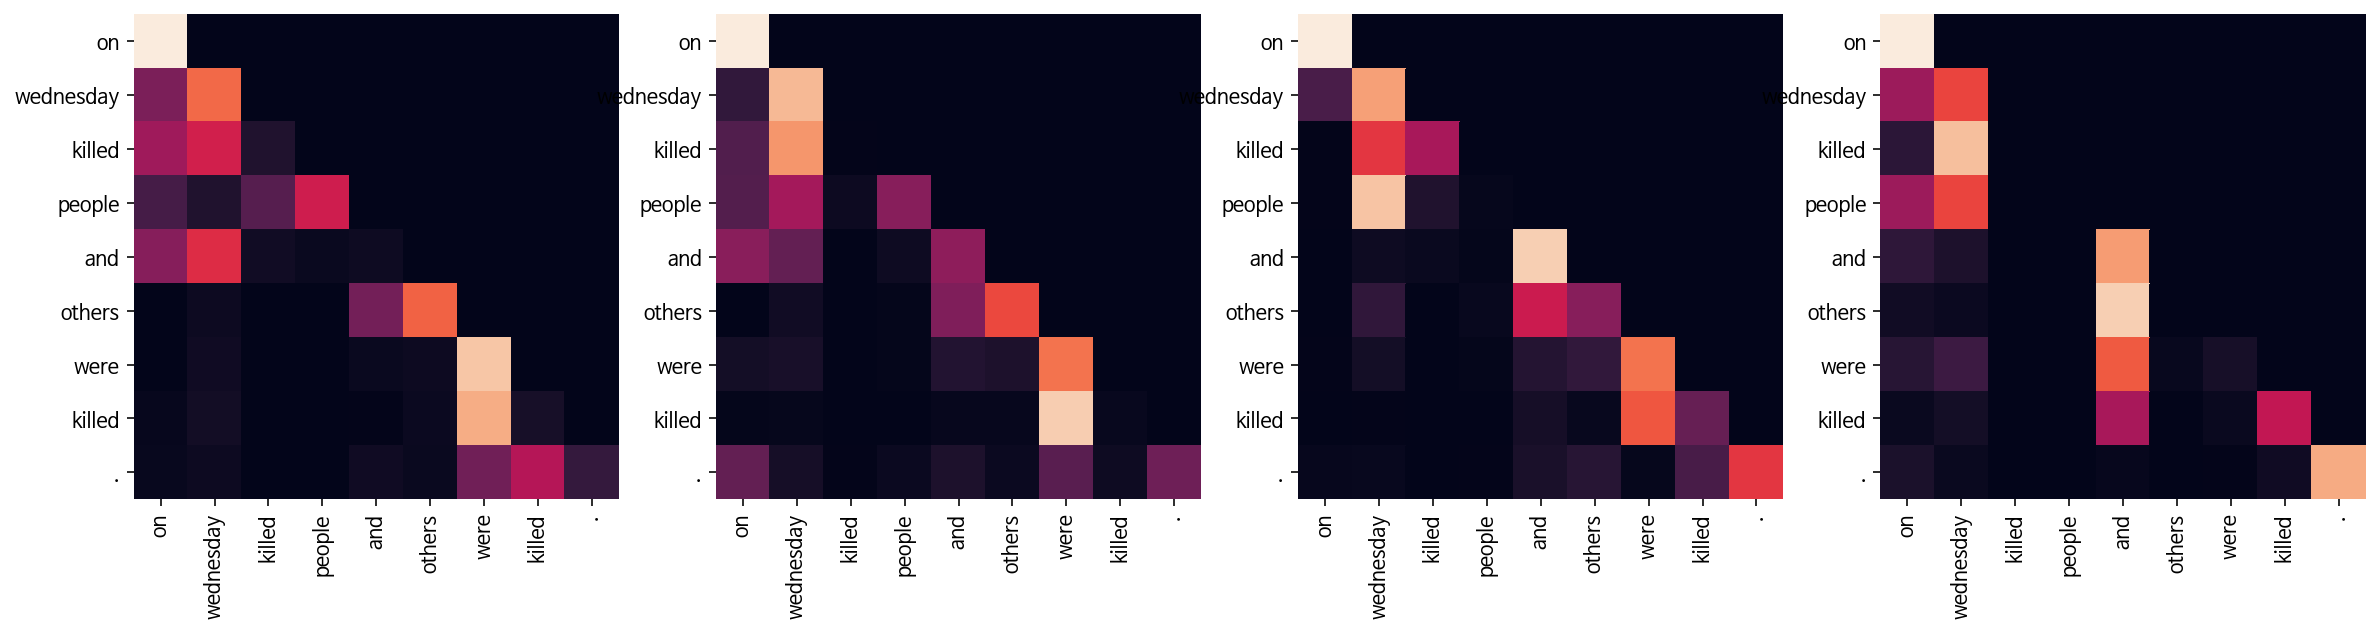

Decoder Src Layer 2


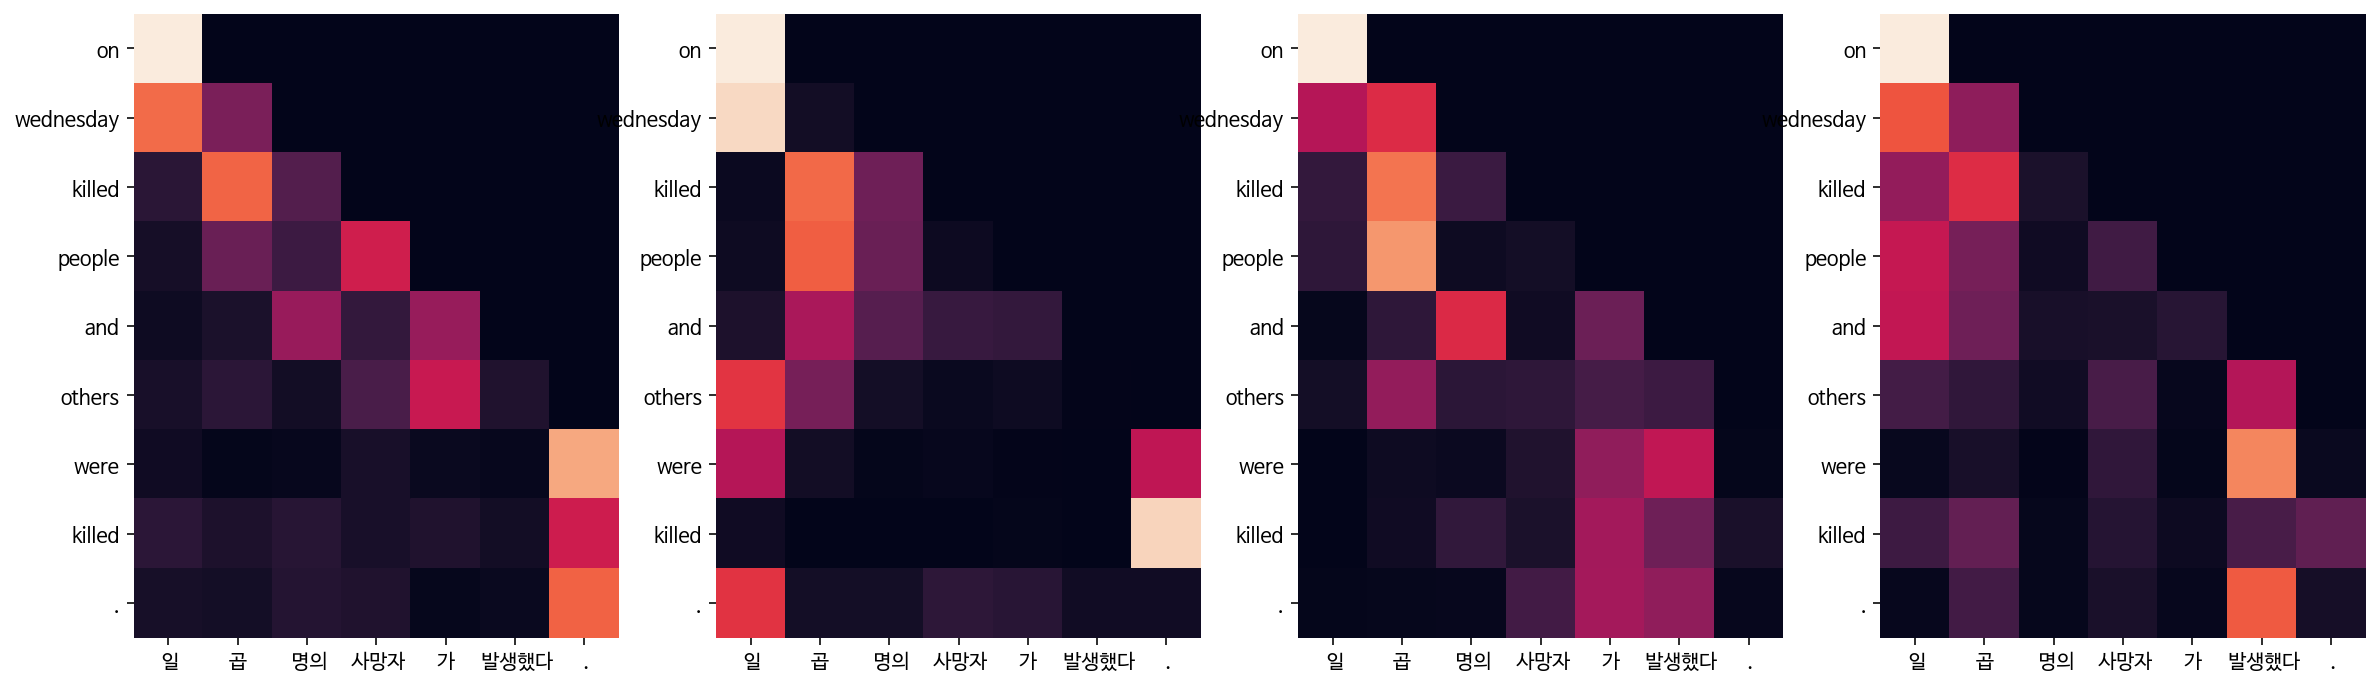

In [37]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 1


for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

- <mark>def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=True):</mark>
    - translate() 함수의 plot_attention 변수를 True 로 주면 번역 결과에 대한 Attention Map을 시각화 해볼 수 있습니다.

## 회고

- 사전 학습 노드 순서와 동일하게 마스크 생성을 진행할경우  에러가 있었던것 같다.
    - 12. 번역가는 대화에도 능하다 노드 순서에 따라 마스크 생성해보니 (10)Transformer 전체 모델 조립 전에 넣으면 훈련 학습 이후 오류발생 이에 (10) Transformer 전체 모델 조립 이후에 (11)마스크 생성으로 마무리할것

- 트랜스포머 내용이 너무 방대해서 포기하고 싶었는데 끝까지 완성하여 뿌듯하다.. 코드가 너무 길어서 다시 읽어봐야 될것 같다.

[창호 퍼실님의 학습 정보]

- <a href="https://www.youtube.com/watch?v=YAgjfMR9R_M&list=PL5-TkQAfAZFbzxjBHtzdVCWE0Zbhomg7r&index=14" target="_blank"> 유튜브 미시건 attention </a>

- <a  href="https://www.youtube.com/watch?v=M3MjaBmcI84" target="_blank"> 유튜브 한경훈 밑시딥2 13강. seq2seq </a>

- <a  href="https://medium.com/platfarm/%EC%96%B4%ED%85%90%EC%85%98-%EB%A9%94%EC%BB%A4%EB%8B%88%EC%A6%98%EA%B3%BC-transfomer-self-attention-842498fd3225" target="_blank"> 내가 찾아본 attention 읽어볼 블로그  </a>

<제안>
- 이론 부분이 앞에 나오고 과제가 뒤에 나왔으면 좋겠다. 해당 10번 과제 제출건은 12번 노드의 내용을 많이 참조 하였다.